# Survival analysis: a machine learning approach using scikit-survival

## Introduction

Survival analysis is a branch of statistics that analyses the expected duration of time till one or more events will happen. While less well-known as classification approaches to these kind of questions, its outcomes are far richer: estimated probabilties that an event will happen during any time interval, expected remaining lifetime,... . Its all in there! In this notebook, I present a survival machine learning approach to predict customer churn. 

The goals of this notebook are threefold: 
- setting-up a machine learning pipeline for survival analysis, 
- comparing different survival machine learning models according to different performance metrics, 
- compare survival machine learning outcomes with classification exercises. 

I will not go over the basics of survival analysis again. If you are interested in these, I invite you to take a look at the notebook survival-basics.ipynb.

Have a nice read,   
  
Robrecht

## Setting-up work environment

In [4]:
import os
import csv
print(os.getcwd())

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import lifelines
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import NelsonAalenFitter

#import scikit-survival as sksurv

%run "helper-functions";

C:\Users\vande70\OneDrive - Cronos\Cursussen\Survival Analysis\code


In [5]:
churn = pd.read_csv('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID', na_values=[' '])
print(churn.shape)
print(churn.head())
#print(churn.isnull().sum()

(7043, 20)
            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
7590-VHVEG  Female              0     Yes         No       1           No   
5575-GNVDE    Male              0      No         No      34          Yes   
3668-QPYBK    Male              0      No         No       2          Yes   
7795-CFOCW    Male              0      No         No      45           No   
9237-HQITU  Female              0      No         No       2          Yes   

               MultipleLines InternetService OnlineSecurity OnlineBackup  \
customerID                                                                 
7590-VHVEG  No phone service             DSL             No          Yes   
5575-GNVDE                No             DSL            Yes           No   
3668-QPYBK                No             DSL            Yes          Yes   
7795-CFOCW  No phone service             DSL            Yes          

## Data cleaning

### Correct types

In [6]:
print(churn.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
dtypes: float64(2), int64(2), object(16)
memory usage: 1.1+ MB


In [7]:
churn[churn.select_dtypes(['object']).columns] = churn.select_dtypes(['object']).apply(lambda x: x.astype('category'))

In [8]:
# Set churn as numeric as categorical variables are not admitted by a lot of models
pd.value_counts(churn['Churn'])
churn["Churn"] = np.where(churn['Churn']=='Yes', 1, 0)
print(pd.value_counts(churn['Churn']) / len(churn))

0    0.73463
1    0.26537
Name: Churn, dtype: float64


In [9]:
churn["SeniorCitizen"] = np.where(churn['SeniorCitizen']==1, 'Yes', 'No')
churn["SeniorCitizen"] = churn["SeniorCitizen"].astype('category')
print(pd.value_counts(churn['SeniorCitizen']))

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64


In [10]:
print(churn.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
gender              7043 non-null category
SeniorCitizen       7043 non-null category
Partner             7043 non-null category
Dependents          7043 non-null category
tenure              7043 non-null int64
PhoneService        7043 non-null category
MultipleLines       7043 non-null category
InternetService     7043 non-null category
OnlineSecurity      7043 non-null category
OnlineBackup        7043 non-null category
DeviceProtection    7043 non-null category
TechSupport         7043 non-null category
StreamingTV         7043 non-null category
StreamingMovies     7043 non-null category
Contract            7043 non-null category
PaperlessBilling    7043 non-null category
PaymentMethod       7043 non-null category
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null int32
dtypes: category(16), float64(2

### Data cleaning

In [11]:
for i in churn.select_dtypes(include='category'):
    print(pd.value_counts(churn[i]))
for i in churn.select_dtypes(include=['int64', 'float']):
    print(churn[i].describe())

Male      3555
Female    3488
Name: gender, dtype: int64
No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64
Yes    6361
No      682
Name: PhoneService, dtype: int64
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
No                     2810
Yes            

We remove all tenure equal to zero as these cannot be accepted by some models and are quite absurd to use. 

In [12]:
churn = churn[churn['tenure'] > 0]
print(churn[['tenure', 'Churn']].describe())

            tenure        Churn
count  7032.000000  7032.000000
mean     32.421786     0.265785
std      24.545260     0.441782
min       1.000000     0.000000
25%       9.000000     0.000000
50%      29.000000     0.000000
75%      55.000000     1.000000
max      72.000000     1.000000


Now, we move on by inspecting the missings. There seems to be no missings, hence easy peasy go

In [13]:
print(churn.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Now, lets clean-up the content of the categorical variables.

### Select correct sample (row-wise and column-wise)

Since there are no missings and we filtered allready all observations with tenure equal to zero, we only check some columns. Most importantly to see if there is some multicollinearity.

First, lets take a look at the correlations between the continuous variables.

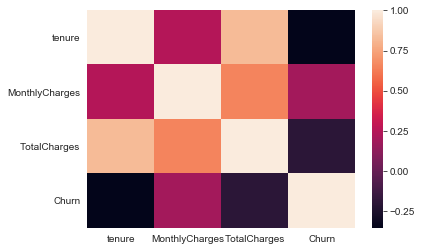

In [48]:
corr_mat = churn.corr()

sns.heatmap(corr_mat, 
            xticklabels=corr_mat.index.values,
            yticklabels=corr_mat.columns.values)
plt.show()

In [49]:
print(corr_mat)

                  tenure  MonthlyCharges  TotalCharges     Churn
tenure          1.000000        0.246862      0.825880 -0.354049
MonthlyCharges  0.246862        1.000000      0.651065  0.192858
TotalCharges    0.825880        0.651065      1.000000 -0.199484
Churn          -0.354049        0.192858     -0.199484  1.000000


Second, lets take a look at the association between the categorical variables.

In [50]:
print('Cramers V:', cramers_v(cat1='SeniorCitizen', cat2='Contract', data=churn))

Cramers V: 0.1421771426428549


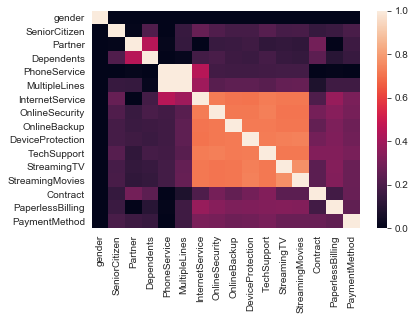

In [51]:
cat = churn.select_dtypes(include='category').columns
cramersv_mat = pd.DataFrame(index=cat, columns=cat)
cramersv_mat = cramersv_mat.fillna(0) # with 0s rather than NaNs

for i, j in enumerate(cat): 
    for u, v in enumerate(cat):
        cramersv_mat.iloc[i, u] = cramers_v(cat1=j, cat2=v, data=churn)

sns.heatmap(cramersv_mat, 
            xticklabels=cramersv_mat.columns.values,
            yticklabels=cramersv_mat.index.values)
plt.show()
#print(cramersv_mat)

Last, lets take a look at the association between a categorical and continuous variable.

In [ ]:
print('Correlation Ratio:', correlation_ratio(cat='SeniorCitizen', cont='MonthlyCharges', data=churn))

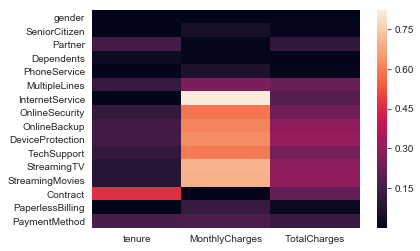

In [47]:
# In matrix
cat = churn.select_dtypes(include='category').columns
cont = churn.select_dtypes(include=['int64', 'float']).columns
corratio_mat = pd.DataFrame(index=cat, columns=cont)
corratio_mat = corratio_mat.fillna(0) # with 0s rather than NaNs

for i, j in enumerate(cat): 
    for u, v in enumerate(cont):
        corratio_mat.iloc[i, u] = correlation_ratio(cat=j, cont=v, data=churn)

sns.heatmap(corratio_mat, 
            xticklabels=corratio_mat.columns.values,
            yticklabels=corratio_mat.index.values)
plt.show()
#print(corratio_mat)

Based on the above analysis, we decide to drop a few variables as they appear to be to highly associated with the other ones. 

In [ ]:
to_drop = ['MonthlyCharges', 'PhoneService']
churn.drop(churn[to_drop], axis=1, inplace=True)

In [ ]:
print(churn.columns)

## Descriptive statistics

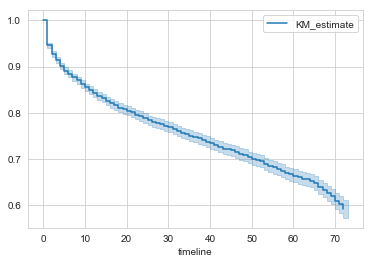

In [52]:
kmf = KaplanMeierFitter()
kmf.fit(churn['tenure'], event_observed=churn['Churn'])
kmf.plot()

In [53]:
#xvar = 'SeniorCitizen'
xvars = list(set(churn.iloc[:,0:4].columns) - set(['tenure', 'Churn']))
print(xvars)

['SeniorCitizen', 'Dependents', 'gender', 'Partner']


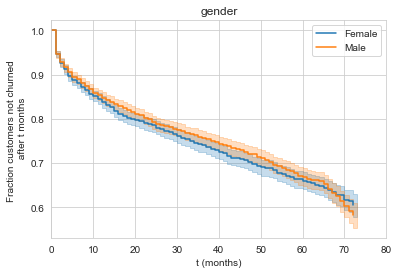

In [54]:
xvar = 'gender'
ax = plt.subplot(111)

for name, grouped_df in churn.groupby(xvar):
    kmf.fit(grouped_df['tenure'], grouped_df['Churn'], label=name)
    kmf.plot(ax=ax, legend=True)
    plt.title(xvar)
    plt.xlim(0, 80)
    plt.ylabel('Fraction customers not churned \n after t months')
    plt.xlabel('t (months)')
    #plt.show()

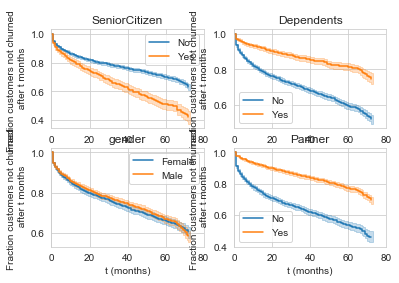

In [55]:
for i, xvar in enumerate(xvars):
    ax = plt.subplot(2, 2, i+1)
    for name, grouped_df in churn.groupby(xvar):
        kmf.fit(grouped_df['tenure'], grouped_df['Churn'], label=name)
        kmf.plot(ax=ax, legend=True)
        plt.title(xvar)
        plt.xlim(0, 80)
        plt.ylabel('Fraction customers not churned \n after t months')
        plt.xlabel('t (months)')

## Survival machine learning

## How does survival ml compares to classification ml?

## Summary